In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    recall_score,
    classification_report,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load Data set

In [2]:
data = pd.read_csv("bank-additional.csv", sep=";")

Data Preprocessing

In [3]:
# Check missing data
print("Missing Values:", data.isnull().sum().sum())

Missing Values: 0


Handle "unknown" values

In [4]:
# Columns has unknown values
columns_have_unknown_val = data.columns[data.isin(["unknown"]).any()]
print(columns_have_unknown_val)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan'], dtype='object')


In [5]:
# Replace 'unknown' with NaN in columns
data = data.replace("unknown", np.nan)

In [6]:
# Check NaN values
print("\nNaN values:", data.isnull().sum().sum())


NaN values: 1230


In [7]:
# Replace the NaN values by most frequent category using fillna func
data["job"] = data["job"].fillna(data["job"].mode()[0])
data["marital"] = data["marital"].fillna(data["marital"].mode()[0])
data["education"] = data["education"].fillna(data["education"].mode()[0])
data["default"] = data["default"].fillna(data["default"].mode()[0])
data["housing"] = data["housing"].fillna(data["housing"].mode()[0])
data["loan"] = data["loan"].fillna(data["loan"].mode()[0])

In [8]:
print("\nNaN values - After replacing:", data.isnull().sum().sum())


NaN values - After replacing: 0


In [9]:
# Encode categorical variables
categorical_cols = [
    "job",  # "admin.","blue-collar",...
    "marital",  #  "divorced","married", ...
    "education",  #  "basic.4y","basic.6y",...
    "default",  #  "no","yes","unknown"
    "housing",  #  "no","yes","unknown"
    "loan",  #  "no","yes","unknown"
    "contact",  #   "cellular","telephone"
    "month",  #   "jan","feb","mar",...,"dec"
    "day_of_week",  #  "mon","tue","wed","thu","fri"
    "poutcome",  #  "failure","nonexistent","success"
]

# convert into numerical values
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

In [10]:
# convert into numerical values
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

In [11]:
# Encode target variable
data["y"] = data["y"].map({"yes": 1, "no": 0})

In [12]:
# Check balanced or imbalanced label
print(data["y"].value_counts())

y
0    3668
1     451
Name: count, dtype: int64


In [13]:
# Separate features and target
x = data.drop("y", axis=1)
y = data["y"]

In [14]:
# Splitting training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

Train Model

In [15]:
# train model func
def train_model(x_train, y_train):
    # Hyperparameters tuning using GridSearchCV
    param_grid = {
        "n_estimators": [100, 200, 500, 1000],
        "max_depth": [None, 5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt"],
        "bootstrap": [True, False],
    }

    # best params for recall
    random_forest_grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42, class_weight="balanced"),
        param_grid=param_grid,
        scoring="recall",
        cv=5,
        n_jobs=-1,
        verbose=1,
    )

    random_forest_grid_search.fit(x_train, y_train)

    print("\nBest Parameters for model:", random_forest_grid_search.best_params_)

    # Model with best hyperparameters
    best_random_forest = random_forest_grid_search.best_estimator_
    best_random_forest.fit(x_train, y_train)

    return best_random_forest

Evaluate model

In [16]:
# evaluation model func
def evaluate_model(model, x_test, y_test):
    y_predict = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]

    print("Model Performance Metrics")
    print("AUC score:", round(roc_auc_score(y_test, y_pred_proba), 4))
    print("Recall:", round(recall_score(y_test, y_predict), 4))
    print("Classification Report:\n", classification_report(y_test, y_predict))
    print("===========================================\n")

    # plot results
    confusion_matrix_baseline = confusion_matrix(y_test, y_predict)
    sns.heatmap(
        confusion_matrix_baseline,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Predicted 0", "Predicted 1"],
        yticklabels=["True 0", "True 1"],
    )
    plt.title("Confusion Matrix")
    plt.show()

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best Parameters for model: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Model Performance Metrics
AUC score: 0.939
Recall: 0.8889
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92       734
           1       0.45      0.89      0.60        90

    accuracy                           0.87       824
   macro avg       0.72      0.88      0.76       824
weighted avg       0.93      0.87      0.89       824




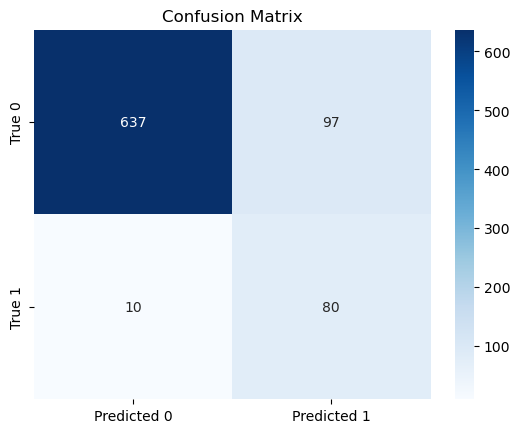

In [17]:
# Train
model_with_best_params = train_model(x_train, y_train)
# Evaluate
evaluate_model(model_with_best_params, x_test, y_test)

Further Improvement

In [18]:
# Feature Importance
importances = model_with_best_params.feature_importances_
features = x.columns
feature_importances = pd.Series(importances, index=features).sort_values(
    ascending=False
)

In [19]:
print("Top 10 Feature Importances:")
print(feature_importances.head(10))

Top 10 Feature Importances:
duration          0.372776
nr.employed       0.179610
euribor3m         0.125164
emp.var.rate      0.091182
pdays             0.046991
cons.conf.idx     0.045146
cons.price.idx    0.035213
poutcome          0.021964
previous          0.015263
month             0.014597
dtype: float64


In [20]:
top_10_features_index = list(feature_importances.head(10).index)
# Subset the test and train sets
x_test_top10 = x_test[top_10_features_index]
x_train_top10 = x_train[top_10_features_index]

In [21]:
# Training model on important features
model_with_best_params_train_on_important_features = train_model(
    x_train_top10,
    y_train,
)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best Parameters for model: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000}



Model train on important features
Model Performance Metrics
AUC score: 0.9479
Recall: 0.9111
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       734
           1       0.45      0.91      0.60        90

    accuracy                           0.87       824
   macro avg       0.72      0.89      0.76       824
weighted avg       0.93      0.87      0.89       824




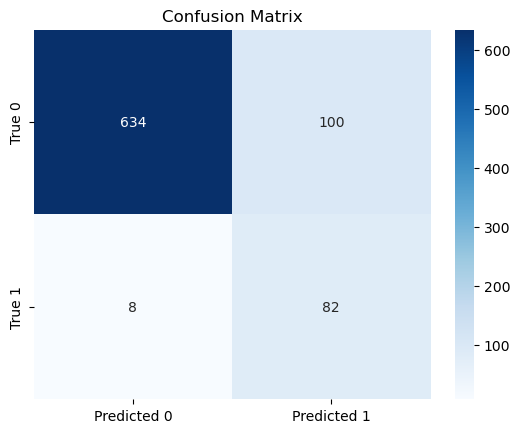

In [22]:
print("\nModel train on important features")
# Evaluate improved solution
evaluate_model(model_with_best_params_train_on_important_features, x_test_top10, y_test)